In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('merged_data.csv', sep='\t', encoding='utf-8')

try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass

In [2]:
target_features = ['ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total']

def plot_expected_vs_predicted(model, train_test, force_predicted=None):
    comparison = pd.DataFrame(train_test['val_y']) # the expected values

    if force_predicted is None:
        comparison['predicted'] = model.predict(train_test['val_X'])
    else:
        comparison['predicted'] = force_predicted

    predicted_feature = comparison.columns[0]

    comparison = comparison.sort_values(by=[predicted_feature])

    comparison = comparison.reset_index(drop=True)

    model_name = type(model).__name__ # RandomForestRegressor, Sequential, etc.
    model_name = 'MLP' if model_name == 'Sequential' else model_name

    # comparison.plot()
    fig, ax = plt.subplots()
    a = comparison[predicted_feature]
    a.plot.line(ax=ax)
    plot = comparison.reset_index().plot.scatter(
        x='index', y='predicted', color="Orange", ax=ax, label='predicitons',
        title=f'predict {predicted_feature} with {model_name}\n(expected VS predicted)'
    )
    plt.show()

def display_mae_r2(model, train_test, force_predicted=None):

        if force_predicted is None:
            val_predictions = model.predict(train_test['val_X'])
        else:
            val_predictions = force_predicted

        mae = mean_absolute_error(train_test['val_y'], val_predictions)
        r2 = r2_score(train_test['val_y'], val_predictions)

        target_feature = train_test['val_y'].name # retrieve target feature from y

        model_name = type(model).__name__ # RandomForestRegressor, Sequential, etc.
        model_name = 'MLP' if model_name == 'Sequential' else model_name

        print(f'Predict {target_feature} with {model_name} :')
        print(f'MeanAbsoluteError:\t{mae}')
        print(f'R2 Score         :\t{r2}\n')

Predict ACCI with RandomForestRegressor :
MeanAbsoluteError:	4.7230897009966775
R2 Score         :	0.6897205485940379



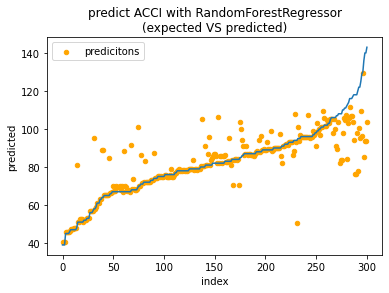

Predict AUTR with RandomForestRegressor :
MeanAbsoluteError:	22.696013289036546
R2 Score         :	0.5343601190065277



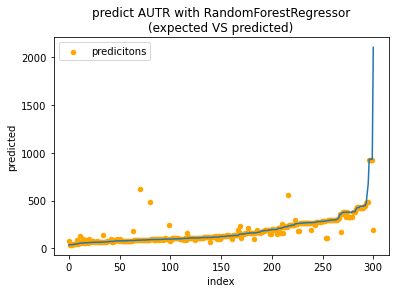

Predict INCN with RandomForestRegressor :
MeanAbsoluteError:	0.8490033222591362
R2 Score         :	0.8978028083116464



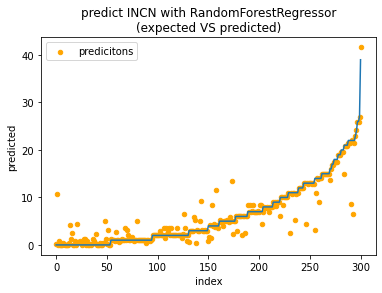

Predict INCU with RandomForestRegressor :
MeanAbsoluteError:	5.538305647840533
R2 Score         :	0.865560141360719



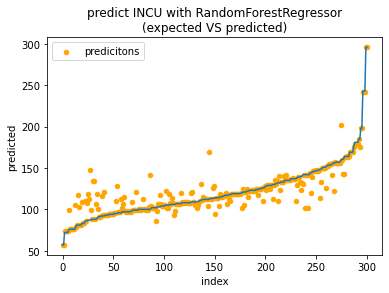

Predict SUAP with RandomForestRegressor :
MeanAbsoluteError:	22.935116279069764
R2 Score         :	0.8919041439475962



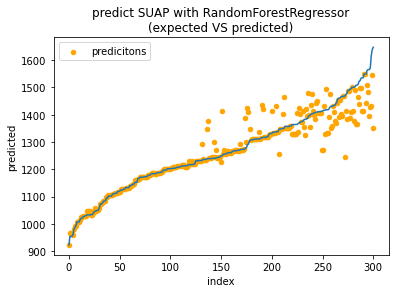

Predict ope_total with RandomForestRegressor :
MeanAbsoluteError:	34.86544850498338
R2 Score         :	0.6878845628080973



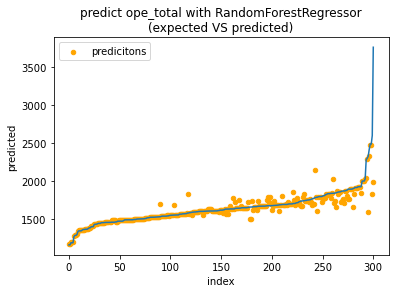

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def do_random_forest(target_feature='SUAP', train_test=None):

    model_random_forest = StandardScaler()

    # All columns except yearweek and all interventions numbers
    features = df.columns[7:]
    to_predict = target_feature

    X = df[features]
    y = df[to_predict]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    X_train = model_random_forest.fit_transform(X_train)
    X_test = model_random_forest.transform(X_test)

    model = RandomForestRegressor(random_state=1)
    model.fit(X_train, y_train)

    return model, {'train_X': X_train, 'val_X': X_test, 'train_y': y_train, 'val_y': y_test}


forest_results = {}
for target in target_features: # loop through 'ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total'
    forest_results[target] = {'model': None, 'train_test': {}}
    forest_results[target]['model'], forest_results[target]['train_test'] = do_random_forest(target)

# display results
for target in forest_results:
    display_mae_r2(
        model=forest_results[target]['model'],
        train_test=forest_results[target]['train_test'],
    )
    plot_expected_vs_predicted(
        model=forest_results[target]['model'],
        train_test=forest_results[target]['train_test'],
    )

In [4]:
from sklearn.preprocessing import Normalizer, StandardScaler, QuantileTransformer
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.layers.core import Dropout
from keras import metrics

##### FIX for "Blas GEMM launch failed" Error
##### see https://stackoverflow.com/a/60699372/12182226
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#####


def do_MLP(target_feature='SUAP', verbose=0):
    # All columns except yearweek and all interventions numbers
    features = df.columns[7:]
    X = df[features]
    y = df[target_feature]
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20)

    #standard scaler
    std_scaler = StandardScaler().fit(X) # fit doesn't affect the data
    train_X = pd.DataFrame(std_scaler.transform(train_X), columns=features)
    val_X = pd.DataFrame(std_scaler.transform(val_X), columns=features)

    # normalize
    normalizer = Normalizer().fit(X) # fit doesn't affect the data
    train_X = pd.DataFrame(normalizer.transform(train_X), columns=features)
    val_X = pd.DataFrame(normalizer.transform(val_X), columns=features)

    model = Sequential()

    #1024, 512, 1
    #4096, 1024, 512, 1

    model.add(Dense(4096, activation='relu', kernel_initializer='random_normal', input_dim=9)) 
    model.add(Dense(1024, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(512, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(1)) #relu, elu, softplus, selu ...

    adam_opt = Adam(learning_rate=0.005) # https://keras.io/api/optimizers/

    model.compile(optimizer=adam_opt, loss="mse", metrics=[metrics.mean_absolute_error])
    model.fit(train_X, train_y, epochs=200 , batch_size=10, verbose=verbose) # 200, 10
    
    return model, {'train_X': train_X, 'val_X': val_X, 'train_y': train_y, 'val_y': val_y}

In [5]:
mlp_results = {}
for target in target_features: # loop through 'ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total'
    mlp_results[target] = {'model': None, 'train_test': {}}
    mlp_results[target]['model'], mlp_results[target]['train_test'] = do_MLP(target_feature=target, verbose=0)
    print(f'{target} done ...')

KeyboardInterrupt: 

Predict ACCI with MLP :
MeanAbsoluteError:	5.3315764462799455
R2 Scote         :	0.7472620532818401



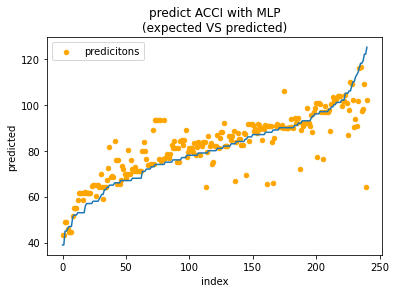

Predict AUTR with MLP :
MeanAbsoluteError:	31.438966933127755
R2 Scote         :	0.7575386012386451



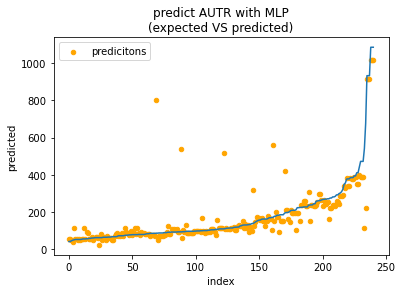

Predict INCN with MLP :
MeanAbsoluteError:	1.022396785342347
R2 Scote         :	0.9025611347803832



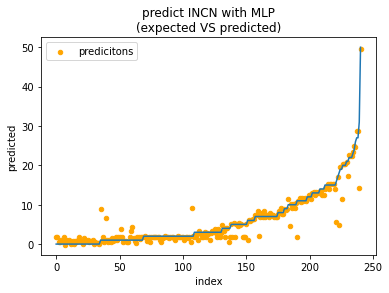

Predict INCU with MLP :
MeanAbsoluteError:	7.33851504820511
R2 Scote         :	0.8637705226695656



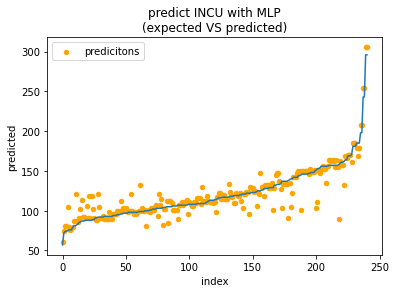

Predict SUAP with MLP :
MeanAbsoluteError:	43.556770293049794
R2 Scote         :	0.7865701459630108



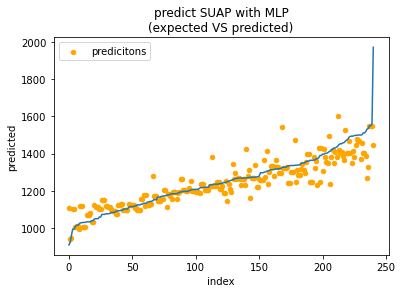

Predict ope_total with MLP :
MeanAbsoluteError:	78.19158251750518
R2 Scote         :	0.6726707202920352



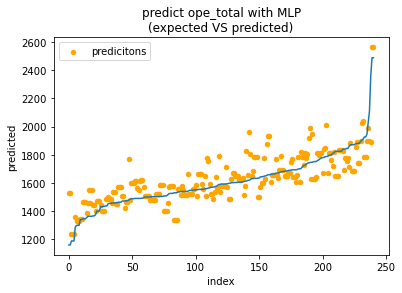

In [219]:
# display results
for target in mlp_results:
    display_mae_r2(
        model=mlp_results[target]['model'],
        train_test=mlp_results[target]['train_test'],
    )
    plot_expected_vs_predicted(
        model=mlp_results[target]['model'],
        train_test=mlp_results[target]['train_test'],
    )

----
(Test) predict ope_total using the predictions of 'ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP'
(the results aren't great)

Predict ope_total with MLP :
MeanAbsoluteError:	217.57492584608403
R2 Score         :	-1.3311917029339244



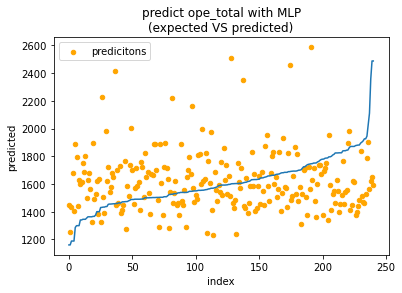

In [247]:
# target_features = ['ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total']
import numpy as np

predictions = []
for target in ['ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP']:
    model = mlp_results[target]['model']
    train_test = mlp_results[target]['train_test']

    val_predictions = model.predict(train_test['val_X'])
    predictions.append(val_predictions)


total = predictions[0]

for i in range (1, len(predictions)):
    total = np.add(total, predictions[i])

display_mae_r2(
    model=mlp_results['ope_total']['model'],
    train_test=mlp_results['ope_total']['train_test'],
    force_predicted=total,
)
plot_expected_vs_predicted(
    model=mlp_results['ope_total']['model'],
    train_test=mlp_results['ope_total']['train_test'],
    force_predicted=total,
)